Preprocessing: Removing pixels with grayscalse intensity $<250$
Model: 4 layers CNN
Implementation of early stopping
# New: Tuning of learning rate

In [1]:
#IMPORT LIBRARIES
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import time
import datetime as dt
import progressbar

import pickle as pkl
import torch
from __future__ import print_function
import argparse
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
#from pytorchtools import EarlyStopping
#import torchvision
#import torchvision.transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.utils.data as data_utils

/home/perreaultlafleur/anaconda3/lib/python3.5/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)
Using TensorFlow backend.


In [3]:
#IMPORT DATA
train_images = pd.read_pickle('train_max_x')
train_answers = pd.read_csv('train_max_y.csv')
test_images = pd.read_pickle('test_max_x')

#Define training, testing and validation datasets
X_train = train_images[0:45000]; X_test=train_images[45000:50000]; X_valid=test_images
y_train = train_answers.loc[0:44999,'Label']; y_test = train_answers.loc[45000:49999,'Label']

#Take out the funky backgrounds
X_train = (X_train>=250).astype(float)*255
X_test = (X_test>=250).astype(float)*255
X_valid = (X_valid>=250).astype(float)*255

#Add one dimension so that it can be an input for the NN
X_train = X_train.reshape(45000, 1, 128, 128)
X_test = X_test.reshape(5000, 1, 128, 128)
X_valid = X_valid.reshape(10000, 1, 128, 128)

#Change the type from numpy to tensor so that it can be an input for the NN
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
X_valid = torch.from_numpy(X_valid)

#do the same for the target vectors
y_train = torch.from_numpy(y_train.to_numpy().reshape(45000))
y_test = torch.from_numpy(y_test.to_numpy().reshape(5000))

#join the x and y values
train = data_utils.TensorDataset(X_train, y_train)
test = data_utils.TensorDataset(X_test, y_test)
valid = data_utils.TensorDataset(X_valid)

#create an iterator that will split the data in batches for training
trainloader = torch.utils.data.DataLoader(train, batch_size=256)
testloader = torch.utils.data.DataLoader(test, batch_size=256)
validloader = torch.utils.data.DataLoader(X_valid, batch_size=256)

In [4]:
class Classifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        # Logistic Regression
        self.clf = nn.Linear(8192, 10)

    def forward(self, x):
        #print(self.conv(x).squeeze().reshape(64,-1).shape)
        out = self.conv(x)
        return self.clf(out.reshape(out.size(0), -1))
        #return self.clf(self.conv(x))


Epoch : 0 Loss : 8.247 
Epoch : 0 Test Acc : 20.300
Epoch : 0 Test Loss : 2.127 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 20.299999237060547 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 1 Loss : 3.049 
Epoch : 1 Test Acc : 20.960
Epoch : 1 Test Loss : 2.210 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 0.6599998474121094 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 2 Loss : 2.272 
Epoch : 2 Test Acc : 23.060
Epoch : 2 Test Loss : 2.233 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 2.1000003814697266 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch 

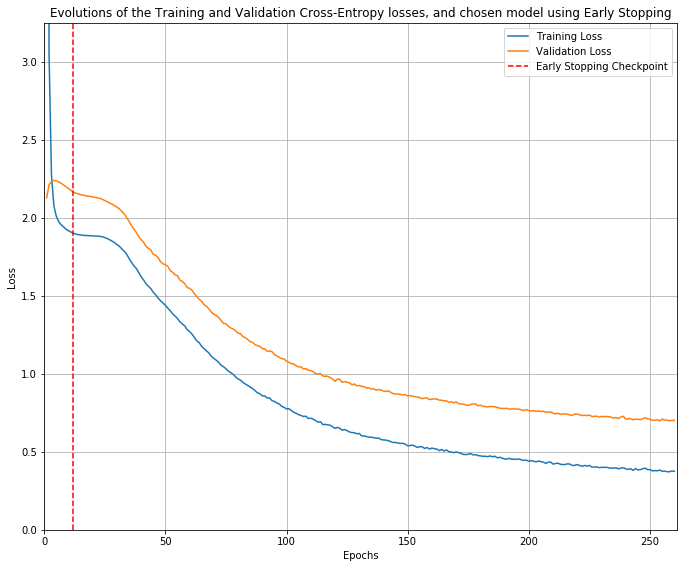

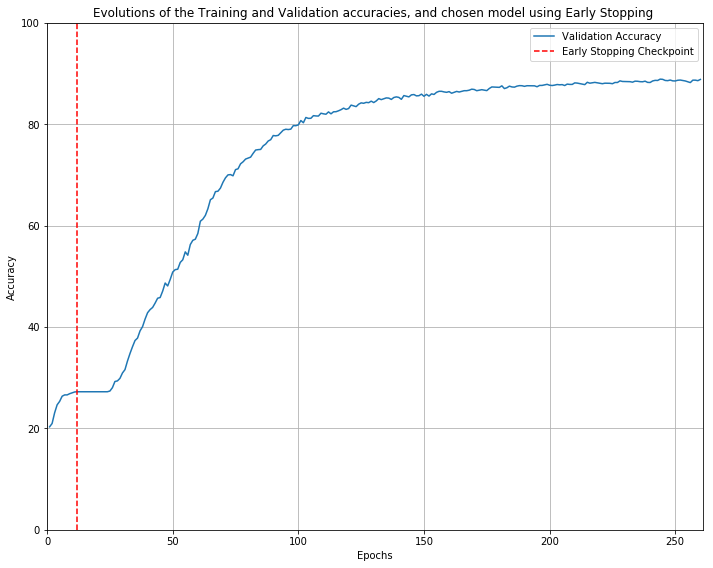


Epoch : 0 Loss : 6.058 
Epoch : 0 Test Acc : 19.080
Epoch : 0 Test Loss : 2.194 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 19.079999923706055 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 1 Loss : 2.362 
Epoch : 1 Test Acc : 21.180
Epoch : 1 Test Loss : 2.232 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 2.1000003814697266 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch : 2 Loss : 2.067 
Epoch : 2 Test Acc : 23.120
Epoch : 2 Test Loss : 2.235 
UPDATE: NEW BEST MODEL
Iterator for early stopping reset to 0 since improvement of test accuracy = 1.9400005340576172 > 0.1
----------------------------------------------------------------------------------------------------------------------------

Epoch 

KeyboardInterrupt: 

In [ ]:
lr_valid_acc=[]
lr_train_loss=[]
lr_valid_loss=[]

for lr in np.arange(0.00005,0.00015,0.00002):

    clf = Classifier()
    optimizer = torch.optim.Adam(clf.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    epochs=260
    time1=dt.datetime.now()

    #Will print the plots
    avg_train_losses = []
    avg_valid_losses = []
    valid_acc = []
    index_of_best = 0

    #Early stopping criterion: when the test accuracy does not improve by at least #epsilon for #patience epochs in a row, we stop
    patience = 5
    epsilon = 0.1
    patience_iterator = 0
    best_test_acc = 0
    last_acc = 0
    stop = False

    #Training for loop
    for epoch in range(epochs):
        losses = []
        # Train
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            optimizer.zero_grad()
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = clf(inputs.float())
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            losses.append(loss.data)
            #print('|', end ="")

        avg_train_losses.append(np.mean(losses))
        print('\nEpoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))

        # Evaluate
        clf.eval()
        total = 0
        correct = 0
        losses = []
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = clf(inputs.float())
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            loss = criterion(outputs, targets)
            losses.append(loss.data)

        avg_valid_losses.append(np.mean(losses))
        test_acc = 100.*correct/total
        valid_acc.append(test_acc)
        print('Epoch : %d Test Acc : %.3f' % (epoch, test_acc))
        print('Epoch : %d Test Loss : %.3f ' % (epoch, np.mean(losses)))

        if test_acc > best_test_acc and not(stop):
            print('UPDATE: NEW BEST MODEL')
            filename = 'best_model_4_lr_%f.mdl' %lr
            torch.save(clf.state_dict(), filename)
            best_test_acc = test_acc
            index_of_best = epoch
        if test_acc <= last_acc + epsilon:
            patience_iterator = patience_iterator + 1
            print('Iterator for early stopping now at '+str(patience_iterator)+' since improvement of test accuracy = '+str((test_acc-last_acc).item())+' <= '+str(epsilon))
        else:
            patience_iterator = 0
            print('Iterator for early stopping reset to 0 since improvement of test accuracy = '+str((test_acc-last_acc).item())+' > '+str(epsilon))
        if patience_iterator == patience:
            stop = True
            print('Early stopping')

        print('----------------------------------------------------------------------------------------------------------------------------')
        last_acc = test_acc
        clf.train()

    #Training time
    time2=dt.datetime.now()
    print('Training time for '+str(epoch)+' epochs: '+str(time2-time1))
    
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
    plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

    # find position of lowest validation loss
    minposs = index_of_best+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 3.25) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.title('Evolutions of the Training and Validation Cross-Entropy losses, and chosen model using Early Stopping')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    #plt.plot(range(1,len(avg_train_losses)+1),valid_acc, label='Training Loss')
    plt.plot(range(1,len(valid_acc)+1),valid_acc,label='Validation Accuracy')

    # find position of lowest validation loss
    minposs = index_of_best+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 100) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.title('Evolutions of the Training and Validation accuracies, and chosen model using Early Stopping ')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    lr_valid_acc.append(valid_acc)
    lr_train_loss.append(avg_train_losses)
    lr_valid_loss.append(avg_valid_losses)
    

In [ ]:
lr_valid_acc

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = index_of_best+1  
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 3.25) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.title('Evolutions of the Training and Validation Cross-Entropy losses, and chosen model using Early Stopping ')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
#plt.plot(range(1,len(avg_train_losses)+1),valid_acc, label='Training Loss')
plt.plot(range(1,len(valid_acc)+1),valid_acc,label='Validation Accuracy')

# find position of lowest validation loss
minposs = index_of_best+1  
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 100) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.title('Evolutions of the Training and Validation accuracies, and chosen model using Early Stopping ')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# MAKE REAL PREDICTIONS

In [23]:
#Later to restore the best model
# load the desired file ! clf.load_state_dict(torch.load('best_model.mdl'))
clf.eval()

Classifier(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Dropout(p=0.5, inplace=False)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Dropout(p=0.5, inplace=False)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Dropout(p=0.5, inplace=False)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (clf): Linear(in_features=8192, out_features=10, bias=True)
)

In [24]:
#Make the final predictions
pred = []
for batch_idx, inputs in enumerate(validloader):
    inputs = Variable(inputs)
    outputs = clf(inputs.float())
    _, predicted = torch.max(outputs.data, 1)
    pred.extend(predicted.tolist())
final_preds = pd.DataFrame()
final_preds['Id'] = list(range(0,10000))
final_preds['Label'] = pred
final_preds.to_csv('Prediction_3.csv', index=False)